# Rainfall-Classification-Analysis

# Imports

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

# Functions

In [127]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()


def evaluate_model(X:pd.Series, y:pd.Series, model):
    """
    This function takes in X, y values
    scores model performance based on
    subsets of data

    Returns:
        scores of models
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    metric = make_scorer(f1_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def create_model_performance_visual(df, y):
    fig, ax = plt.subplots(figsize=(10, 6)) 

    df.plot.bar(x='Model', y=y, ax=ax)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title("Model Performance Comparison", fontsize=16)

    ax.legend(y)
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()


def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series, sampled=False, sampling_model=None):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        if not sampled:
          pipeline = Pipeline(steps=[
          ('scaler', StandardScaler()),
          ("model", model)
        ])
        else:
          pipeline = model
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    performance_df = performance_df.sort_values(by="Mean", ascending=False)
    print(performance_df)
    create_model_performance_visual(performance_df, ["Mean", "STD"])

def create_confusion_matrix(model_name:str, y_test:pd.Series, y_test_pred:pd.Series):
    """
    This function displays a classificaiton report
    & a Confusion Matrix

    Args:
        model_name (str): _description_
        y_test (pd.Series): _description_
        y_test_pred (pd.Series): _description_
    """
    
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test,y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

def get_over_sampling_methods(name, X,y):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  sampling_model = sampling_models[name]
  
  model =  Pipeline(steps=[
        ('scaler', StandardScaler()),
         ("model", sampling_model)
    ])
  
  X_res, y_res = model.fit_resample(X, y)
  return (X_res, y_res)

def test_model_predictions(names, models, X, y):
    
    model_performance = []
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    for i in range(len(models)):
        model, name = models[i],names[i]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        create_confusion_matrix(name, y_test, y_test_pred)
            
        model_performance.append({
                "Model": name,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
        })
    model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)
    print(model_performance_df)
    create_model_performance_visual(model_performance_df, ['Validation Accuracy', 'Test Accuracy'])


# EDA Analysis

In [75]:
df = pd.read_csv("/Users/maukanmir/Downloads/rainfall.csv")
df

,date,rainfall,temperature,humidity,wind_speed,weather_condition
0,2022-01-01,12.5,15.2,78.0,8.5,Rainy
1,2022-01-02,8.2,17.8,65.0,5.2,Rainy
2,2022-01-03,0.0,20.1,52.0,3.1,Sunny
3,2022-01-04,3.7,18.6,71.0,6.7,Rainy
4,2022-01-05,21.1,14.8,82.0,9.3,Rainy
5,2022-01-06,15.3,16.5,75.0,7.8,Rainy
6,2022-01-07,6.8,19.2,61.0,4.5,Rainy
7,2022-01-08,0.0,21.7,48.0,2.9,Sunny
8,2022-01-09,11.2,17.3,73.0,6.1,Rainy
9,2022-01-10,18.6,15.8,79.0,8.9,Rainy


In [76]:
df.dropna(inplace=True)

# Check Class Imbalance

Class=Rainy, Count=42, Percentage=79.245%
Class=Sunny, Count=11, Percentage=20.755%


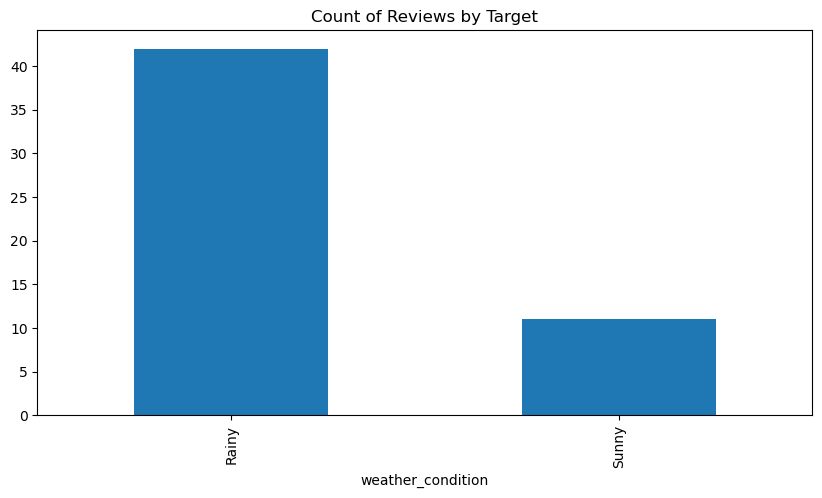

In [77]:
check_class_imbalance(df, df["weather_condition"], "weather_condition")

# Class Imbalance exists here

In [78]:
df.describe()

,rainfall,temperature,humidity,wind_speed
count,53.000000,53.000000,53.000000,53.000000
mean,9.049057,17.950943,69.245283,6.403774
std,6.712521,2.500663,11.969361,2.209069
min,0.000000,13.900000,44.000000,2.100000
25%,3.900000,16.100000,62.000000,4.700000
50%,8.300000,17.800000,72.000000,6.700000
75%,14.800000,19.400000,78.000000,8.300000
max,21.800000,23.400000,89.000000,10.500000


In [79]:
df.dtypes

date                  object
rainfall             float64
temperature          float64
humidity             float64
wind_speed           float64
weather_condition     object
dtype: object

In [80]:
df["date"] = pd.to_datetime(df["date"])

In [81]:
df.dtypes

date                 datetime64[ns]
rainfall                    float64
temperature                 float64
humidity                    float64
wind_speed                  float64
weather_condition            object
dtype: object

In [82]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day 

In [83]:
df

,date,rainfall,temperature,humidity,wind_speed,weather_condition,year,month,day
0,2022-01-01,12.5,15.2,78.0,8.5,Rainy,2022,1,1
1,2022-01-02,8.2,17.8,65.0,5.2,Rainy,2022,1,2
2,2022-01-03,0.0,20.1,52.0,3.1,Sunny,2022,1,3
3,2022-01-04,3.7,18.6,71.0,6.7,Rainy,2022,1,4
4,2022-01-05,21.1,14.8,82.0,9.3,Rainy,2022,1,5
5,2022-01-06,15.3,16.5,75.0,7.8,Rainy,2022,1,6
6,2022-01-07,6.8,19.2,61.0,4.5,Rainy,2022,1,7
7,2022-01-08,0.0,21.7,48.0,2.9,Sunny,2022,1,8
8,2022-01-09,11.2,17.3,73.0,6.1,Rainy,2022,1,9
9,2022-01-10,18.6,15.8,79.0,8.9,Rainy,2022,1,10


In [84]:
df.drop("date", axis=1, inplace=True)

# Visuals

<AxesSubplot:>

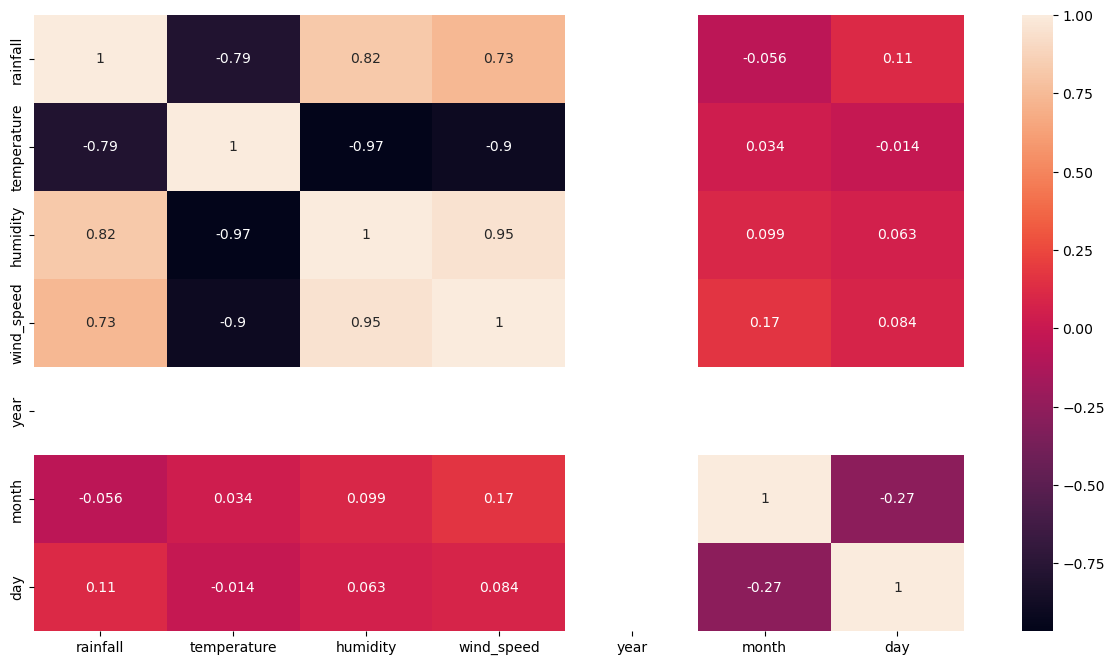

In [85]:
plt.figure(figsize=(15, 8))
sns.heatmap(data=df.corr(), annot=True)

# Separate Feature Variables

In [86]:
X, y = df.drop("weather_condition", axis=1), df["weather_condition"]

# Label Encoder

In [87]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [88]:
model = DummyClassifier(strategy="constant", constant=1)
scores = evaluate_model(X, y, model)
print(f"Mean: {round(np.mean(scores),3)}, STD: {round(np.std(scores),3)}")

Mean: 0.072, STD: 0.023


# Advanced Metrics

  Model      Mean       STD
1   XGB  1.000000  0.000000
0   SVC  0.945397  0.099064
2   GBC  0.923810  0.133333
6   LDA  0.920000  0.135974
3   RFC  0.914286  0.132651
4   DTC  0.900952  0.133415
5    LR  0.900952  0.133415
7   GPC  0.900952  0.133415


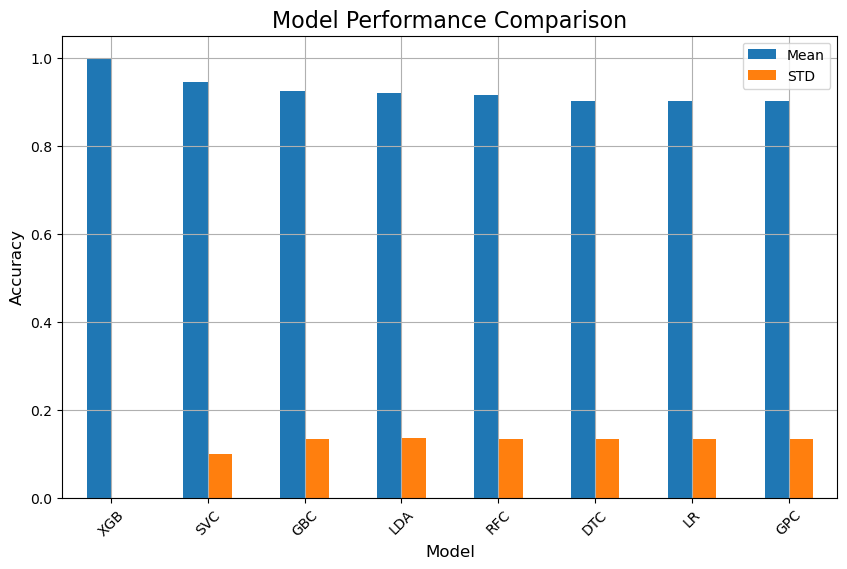

In [123]:
names = ["SVC", "XGB", "GBC", "RFC", "DTC", "LR", "LDA", "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

# Model is overfitting, lets try over sampling methods and possibly regulrizations problems

# SMOTE

In [121]:
X_smote, y_smote = get_over_sampling_methods("SMOTE", X, y)

Validation Test accuracy for SVC: 0.923
Test accuracy for SVC: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



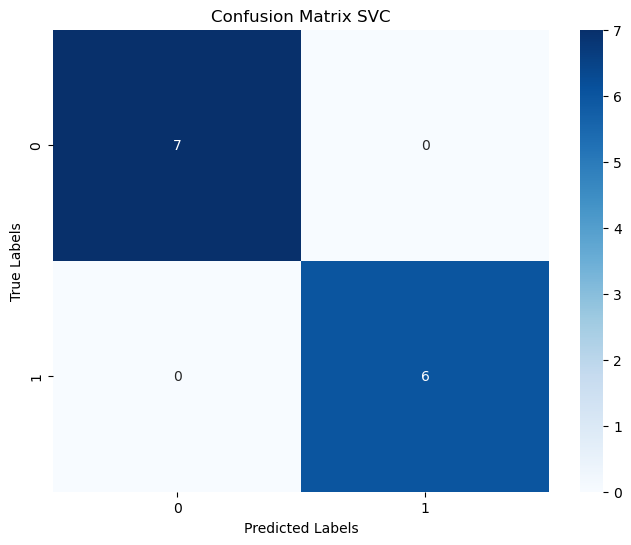

Validation Test accuracy for XGB: 1.000
Test accuracy for XGB: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



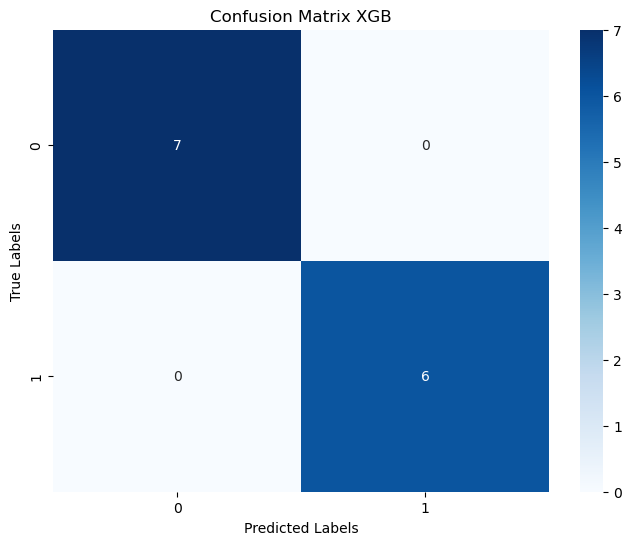

Validation Test accuracy for GBC: 0.923
Test accuracy for GBC: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



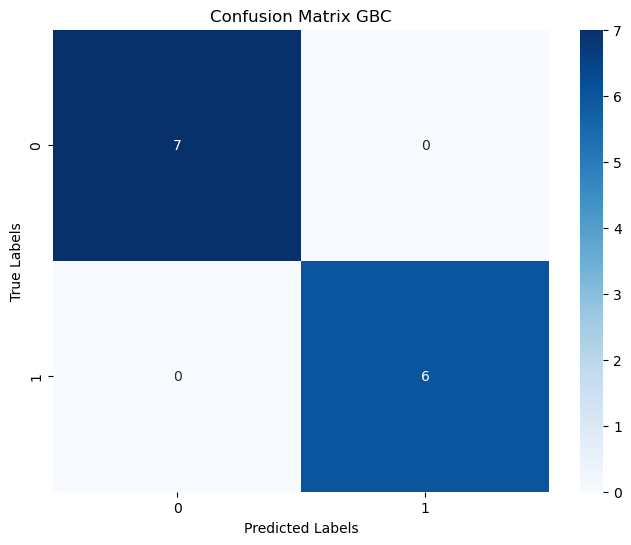

Validation Test accuracy for RFC: 0.923
Test accuracy for RFC: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



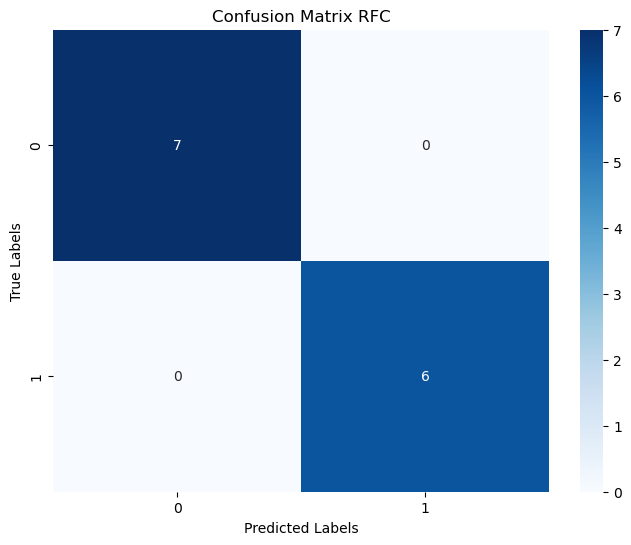

Validation Test accuracy for DTC: 1.000
Test accuracy for DTC: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



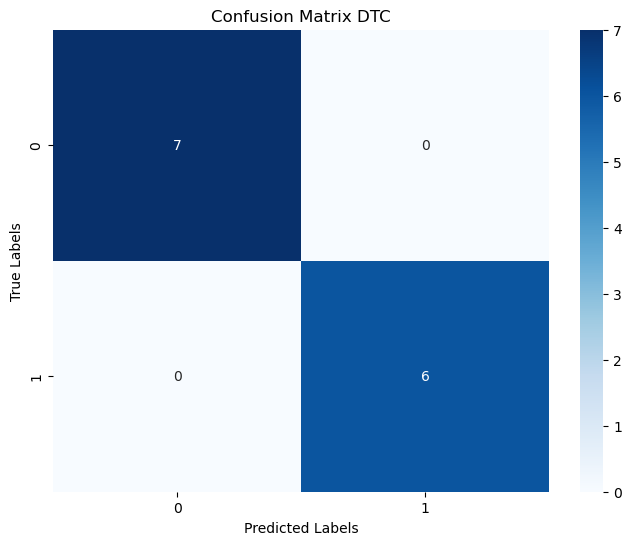

Validation Test accuracy for LR: 0.923
Test accuracy for LR: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



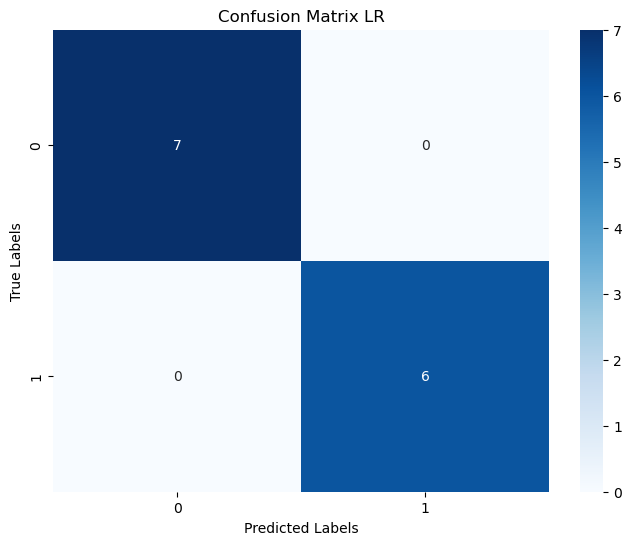

Validation Test accuracy for LDA: 0.923
Test accuracy for LDA: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



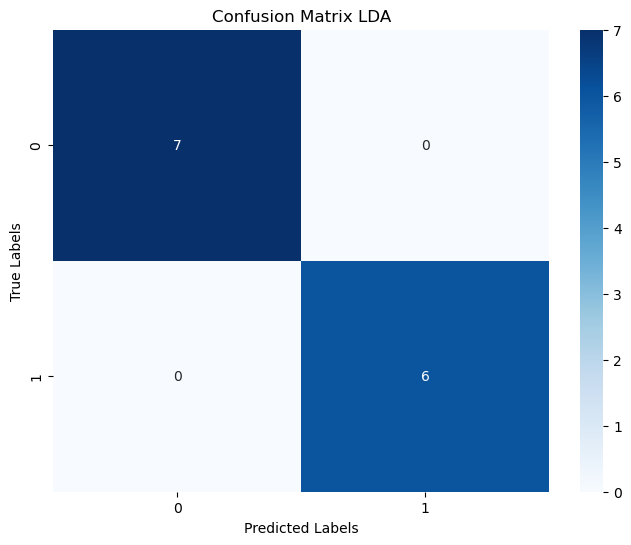

Validation Test accuracy for GPC: 0.923
Test accuracy for GPC: 1.000
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



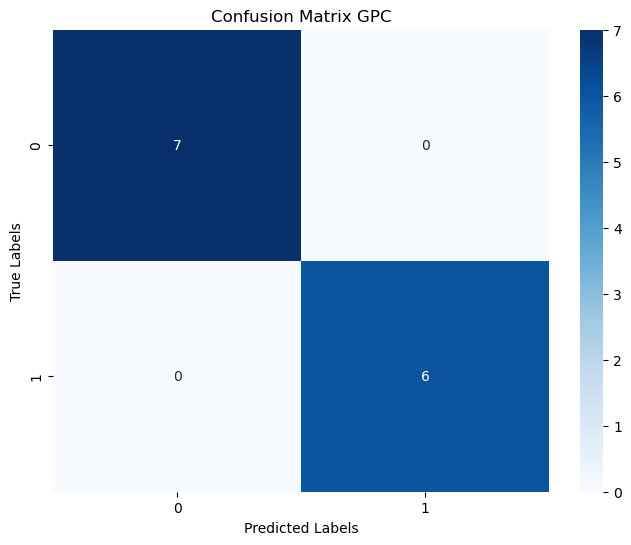

  Model  Validation Accuracy  Test Accuracy
0   SVC             0.923077            1.0
1   XGB             1.000000            1.0
2   GBC             0.923077            1.0
3   RFC             0.923077            1.0
4   DTC             1.000000            1.0
5    LR             0.923077            1.0
6   LDA             0.923077            1.0
7   GPC             0.923077            1.0


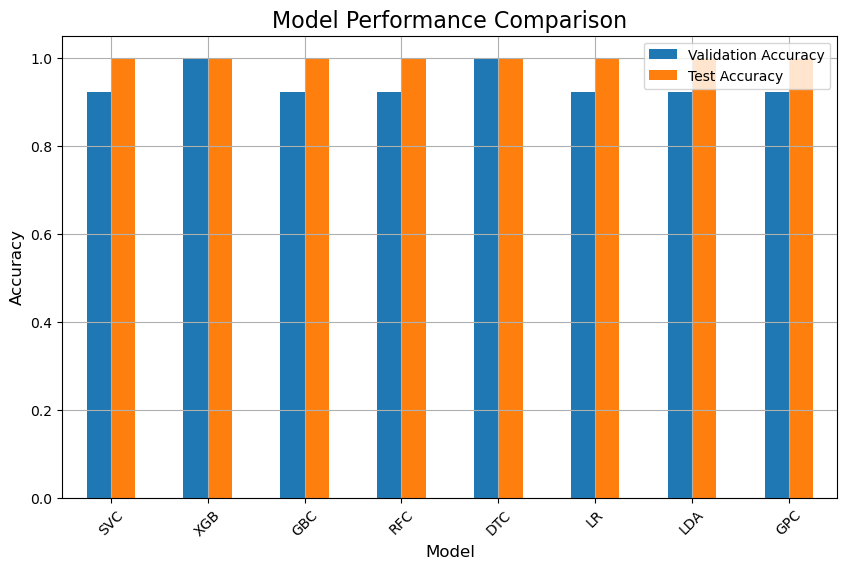

In [128]:
test_model_predictions(names, models, X_smote, y_smote)

# Conclusion: Lack of data is leading to the model overfitting, if we received more data we could increase our predictions